### This phase of the development notebook is mostly to figure out the TBC code, and refine the video RF decoding code.

In [1]:
# Just your usual setup

import numpy as np
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 
import matplotlib.pyplot as plt
import sys
import getopt

%matplotlib inline

import matplotlib
matplotlib.rc('figure', figsize=(20, 12))

from datetime import  datetime

import fft8 as fft8 
import ld_utils as utils

import copy

# for image display
from PIL import Image
from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode

In [2]:
pi = np.pi
tau = np.pi * 2

# Optimal if this is a power of 2
blocklenk = 16
blocklen = (blocklenk * 1024)
# may need to adjust this depending on block length
blockcut = 512

In [3]:
# charting/graphing code carried over from earlier development efforts

def dosplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    db = 20 * np.log10(abs(h))

    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print("-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -10) and (db[i - 1] >= -10):
            print("<-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -20) and (db[i - 1] >= -20):
            print("<-20db crossing at ", w[i] * (freq/pi) / 2.0) 

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    plt.show()

def doplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    db = 20 * np.log10(abs(h))
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 

    ax1 = fig.add_subplot(111)

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# plot two filters (haven't tested in a long while!)
def doplot2(B, A, B2, A2, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)
    w2, h2 = sps.freqz(B2, A2)

    begin = 0
    end = len(w)
    chop = 0

    w = w[begin:end]
    w2 = w2[begin:end]
    h = h[begin:end]
    h2 = h2[begin:end]

    v = np.empty(len(w))

    hm = np.absolute(h)
    hm2 = np.absolute(h2)

    v0 = hm[0] / hm2[0]
    for i in range(0, len(w)):
        v[i] = (hm[i] / hm2[i]) / v0

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    v  = 20 * np.log10(v )

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'r')
    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h2)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    angles2 = np.unwrap(np.angle(h2))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.plot(w * (freq/pi) / 2.0, angles2, 'y')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# This matches FDLS-based conversion surprisingly well (i.e. FDLS is more accurate than I thought ;) )
def BA_to_FFT(B, A, blocklen):
    return np.complex64(sps.freqz(B, A, blocklen, whole=True)[1])

# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


In [4]:
# System default specs for NTSC and PAL.

NTSC_hz_ire = (9300000 - 7600000) / 140.0 # Later disks may have a higher white point

SysParams_NTSC = {
    'system_name': 'NTSC',
    
    'audio_lfreq': 2301136,
    'audio_rfreq': 2812499,

    'analog_audio': True,

    'fsc_mhz': (315.0 / 88.0),
    'line_period': 63.5, # in usecs

    # video frequencies 
    # per spec, range from -40 to 100 IRE is 1.7mhz, so 12142 ire/mhz
    'hz_ire': NTSC_hz_ire,
    
    'videorf_sync'  : 8100000-(NTSC_hz_ire * -40),
    'videorf_0ire'  : 8100000,
    'videorf_7.5ire': 8100000+(NTSC_hz_ire*7.5),
    'videorf_100ire': 8100000+(NTSC_hz_ire*100), # NOTE: slightly higher on later disks

    # IRE range is actually -40 to 110, but leave some margin here and match 0-65534 scaling
    'ire_min': -60,
    'ire_max': 140,

    # tunable parameters.  These work well with DD 2_2 + eliptical filter, which is a bit more
    # picky about audio RF filtering.
    
    #'deemp': (120, 320), # actual deemp timing... at least the usec #'s.
    'deemp': (120*.7, 320*.7), # On some captures this is as low as .55.

    # The audio notch filters didn't work right until the ellipcital filter was implemented...
    'audio_filtwidth': 150000,
    'audio_filtorder': 2,

    # similar but not identical to what Pioneer did
    'vbpf': (3500000, 13200000),
    'vbpf_order': 3,
    
    # This can easily be pushed up to 4.5mhz...
    'vlpf_freq': 4200000,   # in mhz
    'vlpf_order': 5 # butterworth filter order
    
}

SysParams_PAL = {
    # System parameters
    'system_name': 'PAL',

    'fsc_mhz': 4.43361875,
    'line_period': 64, # in usecs
    
    'audio_lfreq': 683593,
    'audio_rfreq': 1066400,

    # video frequencies 
    'videorf_sync': 6760000, # on LD this includes a very strong pilot signal
    'videorf_0ire': 7100000,
    'videorf_100ire': 7900000,

    'ire_min': -95, # needed for pilot signal
    'ire_max': 145,

    # changeable defaults
    'analog_audio': False, # not true for later PAL

    'deemp': (100, 400),

    # XXX: guessing here!
    'vbpf': (2600000, 11000000),
    'vbpf_order': 3,
    'vlpf_freq': 4800000,	# in mhz
    'vlpf_order': 5,		# butterworth filter order

    'audio_filtwidth': 200000,
    'audio_filtorder': 1,
}

# support reloading/rerunning from ipython
try:
    # a dummy load
    tmp = SysParams['fsc_mhz']
except:
    SysParams = copy.deepcopy(SysParams_NTSC)
    

In [5]:
params = {'freq': 40}

for p in [SysParams_NTSC]:
    for k in p.keys():
        print(k, p[k])
        params[k] = p[k]

system_name NTSC
audio_lfreq 2301136
audio_rfreq 2812499
analog_audio True
fsc_mhz 3.5795454545454546
line_period 63.5
hz_ire 12142.857142857143
videorf_sync 8585714.285714285
videorf_0ire 8100000
videorf_7.5ire 8191071.428571428
videorf_100ire 9314285.714285715
ire_min -60
ire_max 140
deemp (84.0, 224.0)
audio_filtwidth 150000
audio_filtorder 2
vbpf (3500000, 13200000)
vbpf_order 3
vlpf_freq 4200000
vlpf_order 5


In [6]:
# old lddecode format for hz->uint16 conversion
minire = -60
maxire = 140
hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)
out_scale = 65534.0 / (maxire - minire)

In [7]:
def inrange(a, mi, ma):
    return (a >= mi) & (a <= ma)

def sqsum(cmplx):
    return np.sqrt((cmplx.real ** 2) + (cmplx.imag ** 2))

# crude zero-crossing calculator.

def iretohz(ire):
    return 8100000+(hz_ire_scale*ire)

m20ire = iretohz(-20)

def calczc(data, start_offset, target, count=10):
    if data[start_offset] < target:
        locs = np.where(data[start_offset:start_offset+count] >= target)[0]
        offset = 0
    else:
        locs = np.where(data[start_offset:start_offset+count] <= target)[0]
        offset = -1
    
    if len(locs) == 0:
        return None
        
    x = start_offset + locs[0]
    
    a = data[x - 1] - target
    b = data[x] - target
    
    y = -a / (-a + b)

    #print(x, y, locs, data[start_offset:start_offset+locs[0] + 1])

    return x-1+y


In [8]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*200+[0]*200)
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do the 'heavy lifting'
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

def filtfft(filt, blen = blocklen):
    return sps.freqz(filt[0], filt[1], blen, whole=1)[1]

Decoding notes:

- My RF decoder is based off frequency-domain transforms.  This allows multiple filters to be applied in one operation, and multiple different filters can also be applied, which will come into play when working on audio

In [9]:
# A rather pants attempt at doing an MTF function, but it seems to work well...
[tf_b, tf_a] = sps.zpk2tf(.1, -.5, 1.0)
Fmtf = filtfft([tf_b, tf_a])

# This prepares the needed transforms to do the actual video decoding
def prepare_video_filters(params):
    SP = copy.deepcopy(params)
    
    SP['freq_hz'] = SP['freq'] * 1000000.0
    SP['line_px'] = SP['freq_hz'] * (SP['line_period'] / 1000000.0)
        
    freq_hz = SP['freq_hz']
    freq_hz_half = SP['freq_hz'] / 2
    freq_half = SP['freq'] / 2

    # RF BPF and analog audio cut filters
    SP['FRFVideo'] = filtfft(sps.butter(SP['vbpf_order'], [SP['vbpf'][0]/freq_hz_half, SP['vbpf'][1]/freq_hz_half], btype='bandpass'))
    
    # If there is analog audio, it must be filtered well especially with DD >=2.2 RF captures
    if SP['analog_audio'] and SP['audio_filtorder']: 
        SP['Fcutl'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_lfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_lfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        SP['Fcutr'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_rfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_rfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        
        SP['FRFVideo'] *= (SP['Fcutl'] * SP['Fcutr'])
    
    # standard post-demod LPF
    SP['Fvideo_lpf'] = filtfft(sps.butter(SP['vlpf_order'], SP['vlpf_freq']/freq_hz_half, 'low')) # standard 4.Xmhz

    # post-demodulation deemphasis filter
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10)/2.0, -SP['deemp'][0]*(10**-10)/2.0, SP['deemp'][0] / SP['deemp'][1])
    SP['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half))

    # mostly used for internal tests, but the exact opposite of the above
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][0]*(10**-10)/2.0, -SP['deemp'][1]*(10**-10)/2.0, SP['deemp'][1] / SP['deemp'][0])
    #sps.zpk2tf(-filterset['deemp'][0]*(10**-10)/2.0, -filterset['deemp'][1]*(10**-10)/2.0, filterset['deemp'][1] / filterset['deemp'][0])
    SP['Femp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half))
    
    # Post processing:  lowpass filter + deemp
    SP['FVideo'] = SP['Fvideo_lpf'] * SP['Fdeemp'] 
    
    # additional filters:  0.5mhz and color burst
    SP['F0_5'] = filtfft(sps.butter(1, 0.5/freq_half, 'low')) 
    SP['FVideo05'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['F0_5']

    if SP['system_name'] == 'NTSC':
        bf = sps.firwin(257, [(SP['fsc_mhz'] * .975)/freq_half, (SP['fsc_mhz'] * 1.025)/freq_half], pass_zero=False)
        SP['Fcburst'] = filtfft((bf, [1.0]))
    else:
        SP['Fcburst'] = filtfft(sps.butter(1, [3.7/freq_half, 3.8/freq_half], btype='bandpass')) 
        
    SP['FVideoBurst'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['Fcburst']
    
    # emperical work determined that a single-pole low frequency filter effectively 
    # detects the end of a (regular) sync pulse when binary level detection is used. TODO: test with PAL
    f = sps.butter(1, 0.05/(params['freq'] / 2.0), btype='low')
    SP['FPsync'] = filtfft(f)
    
    return SP

In [10]:
# The actual video demodulation code

def dodemod(paramsc, data, usemtf = False, cutarf = False, return_fft = False):
    indata_fft = np.fft.fft(data)
    indata_fft_filt = indata_fft * paramsc['FRFVideo']

    if usemtf:
        indata_fft_filt *= Fmtf

    hilbert = np.fft.ifft(indata_fft_filt * fft_hilbert)

    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
        dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    # With extremely bad data, the unwrapped angles can jump.
    while np.min(tdangles2) < 0:
        tdangles2[tdangles2 < 0] += tau
    while np.max(tdangles2) > tau:
        tdangles2[tdangles2 > tau] -= tau
    demod = (tdangles2 * (paramsc['freq_hz'] / tau))

    demod_fft = np.fft.fft(demod)
    
    out_video = np.fft.ifft(demod_fft * paramsc['FVideo']).real
    out_video05 = np.fft.ifft(demod_fft * paramsc['FVideo05']).real
    out_videoburst = np.fft.ifft(demod_fft * paramsc['FVideoBurst']).real
    
    # NTSC: filtering for vsync pulses from -55 to -25ire seems to work well even on rotted disks
    output_sync = (out_video > (params['videorf_0ire'] + (params['hz_ire'] * -55))) & (out_video < (params['videorf_0ire'] + (params['hz_ire'] * -25)))
    # Perform FFT convolution of above filter
    output_syncf = np.fft.ifft(np.fft.fft(output_sync) * filterset['FPsync']).real
    
    rv = np.rec.array([out_video, out_video05, output_syncf, out_videoburst], names=['demod', 'demod_05', 'demod_sync', 'demod_burst'])
    if return_fft:
        return rv, demod_fft
    else:
        return rv
    #return out_video, out_video05, out_videoburst

In [11]:
def lineplot(output, param):
    plt.plot(np.clip(output, 7400000, 9450000))
    
    if param['system_name'] == 'PAL':
        plt.axhline(7100000, color='black') # black
        plt.axhline(7900000, color='black') # white

        # burst
        plt.axhline(7100000 - (800000 * 1.5 / 7), color='g')
        plt.axhline(7100000 + (800000 * 1.5 / 7), color='g')

        # pilot low (pilot high is 7.1mhz)
        plt.axhline((7900000-(800000/.7))-(800000*(3/7)), color='b')
    else: # NTSC
        
        plt.axhline(params['videorf_0ire'], color='black') # 0IRE
        plt.axhline(params['videorf_7.5ire'], color='black') # black for most disks
        plt.axhline(params['videorf_100ire'], color='black') # white

        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 80), color='blue')
        
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 20), color='green')
        plt.axhline(params['videorf_0ire'] - (params['hz_ire'] * 20), color='green')
        
        # sync
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * -40), color='blue')

In [12]:
def calcsnr(a):
    stdire = np.std(a) / NTSC_hz_ire
    return(20 * np.log10(100 / stdire))

In [13]:
def demod(infile, _start, _end, filterset, usemtf = False):
    infile_len = infile.seek(0, 2)
    
    if _end > infile_len:
        end = infile_len
    else:
        end = _end
    
    if (_start > blockcut):
        start = _start - blockcut
    else:
        start = 0 # should this be an error?  prolly.

    print(start, end, (end - start))
    
    # set a placeholder
    output = None #np.zeros(end - start + 1, dtype=('double, double, double'))
        
    for i in range(start, end, blocklen - blockcut):
        #print(i, start, end)
        infile.seek(i * sampletype, 0)
        inbuf = infile.read(blocklen * sampletype)
        
        if sampletype == 2:
            indata = np.fromstring(inbuf, 'int16', len(inbuf) // 2)
        else:
            indata = np.fromstring(inbuf, 'uint8', len(inbuf))
    
        if len(indata) < blocklen:
            print('b', len(indata), blocklen )
            break
    
        tmp = dodemod(filterset, indata, usemtf=usemtf)
        
        # if the output hasn't been created yet, do it now using the 
        # data types returned by dodemod (should be faster than multiple
        # allocations...)
        if output is None:
            output = np.zeros(end - start + 1, dtype=tmp.dtype)
        
        if i - start + (blocklen - blockcut) > len(output):
            copylen = len(output) - (i - start)
        else:
            copylen = blocklen - blockcut

        output_slice = slice(i - start, i - start + copylen)
        tmp_slice = slice(blockcut, blockcut + copylen)
            
        output[output_slice] = tmp[tmp_slice]

    #print(output.shape)
    return output

In [14]:
if True: # DD 3.0 beta fantasia example
    params['freq'] = 40.0
    deemp_adj1 = .63
    deemp_adj2 = .525

    params['freq'] = 44.0
    deemp_adj1 = .55
    deemp_adj2 = .55

    
    params['deemp'] = (120*deemp_adj1, 320*deemp_adj2)
    sampletype = 2

    params['vbpf'] = (3500000, 13500000)
    params['vbpf_order'] = 1

    params['vlpf_freq'] = 4200000
    params['vlpf_order'] = 7

else: # cxadc capture
    params['freq'] = 8 * 315 / 88
    sampletype = 1

    deemp_adj = 1
    params['deemp'] = (140*deemp_adj, 320*deemp_adj)
    
    params['vbpf'] = (3500000, 13500000)
    params['vbpf_order'] = 3

    params['vlpf_freq'] = 4200000
    params['vlpf_order'] = 3

filterset = prepare_video_filters(params)

#infile = open('/home/cpage/ldcaps/ggv1069-22000.raw', 'rb')
#infile = open('/home/cpage/erica_44a.raw', 'rb')
#tmp= demod(infile, 50000, 2000000, filterset)

In [15]:
# since the filter parameters can cause many different effects, it is essential 
# to determine filter delays etc automatically

In [16]:
def genwave(rate, freq, initialphase = 0):
    out = np.zeros(len(rate), dtype=np.double)
    
    angle = initialphase
    
    for i in range(0, len(rate)):
        angle += np.pi * (rate[i] / freq)
        if angle > np.pi:
            angle -= tau
        
        out[i] = np.sin(angle)
        
    return out
    
    

In [17]:
# generate a fake signal and (try to ) decode it correctly :)
def calc_demodgaps(filterset):
    # generate a fake signal and (try to ) decode it correctly :)
    #def calc_demodgaps(filterset):
    fakeoutput = np.zeros(blocklen, dtype=np.double)

    # set base level to black
    fakeoutput[:] = 8100000

    # sync
    fakeoutput[1000:1300] = 7600000

    # color burst

    burstlen = int(18 * ((filterset['freq'] / 2) / (315/88)) )
    rate = np.full(burstlen, (315/88.0), dtype=np.double)
    fakeoutput[1500:1500+burstlen] = 8100000 + (genwave(rate, filterset['freq'] / 2) * 250000)

    burstlen = int(64 * ((filterset['freq'] / 2) / (315/88)) )
    rate = np.full(burstlen, (315/88.0), dtype=np.double)
    fakeoutput[0:0+burstlen] = 8100000 + (genwave(rate, filterset['freq'] / 2) * 250000)

    # white
    fakeoutput[2000:3000] = 9100000

    #[tf_b, tf_a] = sps.zpk2tf(-filterset['deemp'][1]*(10**-10)/2.0, -filterset['deemp'][0]*(10**-10)/2.0, filterset['deemp'][0] / filterset['deemp'][1])
    #filterset['Femp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/(filterset['freq_hz'] / 2.0)))

    tmp = np.fft.fft(fakeoutput)
    tmp2 = tmp * filterset['Fvideo_lpf']
    tmp3 = tmp2 * filterset['Femp']

    fakeoutput_lpf = np.fft.ifft(tmp2).real
    fakeoutput_emp = np.fft.ifft(tmp3).real

    fakesignal = genwave(fakeoutput_emp, filterset['freq_hz'] / 2)
    fakedecode = dodemod(filterset, fakesignal)

    filterset['dgap'] = calczc(fakedecode['demod'], 1250, iretohz(-20), 500) - calczc(fakeoutput_emp, 1250, iretohz(-20), 500)
    filterset['dgap_05'] = calczc(fakedecode['demod_05'], 1250, iretohz(-20), 500) - calczc(fakedecode['demod'], 1250, iretohz(-20), 500)

    fdburst_adj = fakedecode['demod_burst'][128:]

    # find the last bottom of the emulated burst, then it's zero crossing
    c17_5 = 1500 + np.argmax(-fdburst_adj[1500:])
    c16_5 = c17_5 - ((filterset['freq'] / 2) / (315/88)) 

    c17 = calczc(fdburst_adj, int(c16_5), 0)
    c17_orig = 1500 + 17 * ((filterset['freq'] / 2) / (315/88)) 

    # find the *phase* difference of the peak (which is actually in the middle of the burst)
    # and the demodulated wave

    c17_demod = calczc(fakedecode['demod'], int(c16_5), 8100000)
    filterset['dgap_burst'] = (c17 - c17_demod)

    # not what we actually want ;)
    #filterset['dgap_burst'] = (c17 - c17_orig) - filterset['dgap']

    return fakeoutput, fakedecode

In [18]:
dg = calc_demodgaps(filterset)

Below this is the less developed code to deal with NTSC framing and syncs.

A plot of output_syncf here shows a nice pattern overall:

- Vsyncs reach 1.0 (and the mininum in those areas is ~0.23)
- regular hsyncs come in about 0.77 (the glitches are where the LD player "rewinds" for still frames)
- equalization pulses come in about 0.5

In [19]:
def findburstfromsync(syncf, center):
    ilinepx = int(filterset['line_px'])

    if syncf[center] < .2:
        print('invalid location')
    try:
        scanarea = (ilinepx * 6)
        threshold = .15

        startsync = center - scanarea + np.where(syncf[center - scanarea:center] < threshold)[0][-1]
        # note: endsync usually includes the first equalization pulse
        #endsync = center + np.where(syncf[center:center + scanarea] < threshold)[0][0]
        endsync1 = center + np.where(syncf[center:center + scanarea] > .95)[0][-1]
        endsync = endsync1 + np.where(syncf[endsync1:endsync1 + scanarea] < threshold)[0][0]
    except:
        print('oh oh, sync ends not found')
        return None

    try:
        lastlinepresync = (startsync - (ilinepx * 6)) + np.where(syncf[startsync - (ilinepx * 6): startsync] > .6)[0][-1]
        # compute equalization length with .08 compensation factor
        presync_eqlen = ((startsync - lastlinepresync) / ilinepx) + .08
    except:
        print("error: couldn't find prev line", startsync)
        lastlinepresync = None
        presync_eqlen = None

    try:
        #print(endsync)
        nextline = endsync + np.where(syncf[endsync: endsync + (ilinepx * 4)] > .6)[0][0]
        # the offset is larger here since the first equalization pulse is close enough to the end of vsync
        postsync_eqlen = ((nextline - endsync) / ilinepx) + .56
    except:
        print("error: couldn't find next line", endsync)
        nextline = None
        postsync_eqlen = None

    #print(lastlinepresync, nextline, presync_eqlen, postsync_eqlen)
    return (lastlinepresync, nextline, presync_eqlen, postsync_eqlen)

#findburstfromsync(rdata['demod_sync'], 190301)

In [20]:
def findsync(output_sync, loc = 0):
    loc = 0

    # find the next sync point.  should be > .9
    syncloc = np.argmax(output_sync[loc:loc+imglen]) + loc

    if np.max(output_sync[loc:loc+imglen]) < .9:
        #print("oops.  can't find a good sync")
        return (None, None, None)
    
    rv = findburstfromsync(output_sync, syncloc)
    if rv is None:
        return None, None, None
    
    prevline, nextline, pregap, postgap = rv

    print(np.max(output_sync[loc:loc+imglen]), pregap, postgap)
    
    if pregap >= 3.75:
        firstfield = False
    else:
        firstfield = True
    
    return syncloc, firstfield, nextline

In [21]:
imglen = (int)((filterset['freq_hz'] / 59.976) * 1.25)

def findfirstframe(infile, start = 0):
    readlen = int(128 * filterset['line_px'])

    loc = start
    while (loc - start) < filterset['freq_hz']:
        data = demod(infile, loc, loc + readlen, filterset)
        
        if np.max(data['demod_sync']) > .9:
            if (np.argmax(data['demod_sync']) / filterset['line_px']) > 100:
                loc += np.argmax(data['demod_sync']) - int(16 * filterset['line_px'])
                continue
        else:
            loc += int(120 * filterset['line_px'])
            continue
                
        print(loc, np.max(data['demod_sync']), np.mean(data['demod_sync']))
        syncloc, firstfield, nextline = findsync(data['demod_sync'])
        
        print(loc, loc + syncloc, firstfield, np.max(data['demod_sync']), np.mean(data['demod_sync']))
        
        if syncloc and not firstfield:
            loc += int(240 * filterset['line_px'])
            #return loc + nextline, data
        elif syncloc and firstfield:
            return loc + nextline, data
    
    return None

In [22]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = int(begin)
        iend = int(end)
        linelen = end - begin

        dist = iend - ibegin + 0
        
        sfactor = dist / tgtlen
        
        arr, step = np.linspace(0, dist, num=dist + 1, retstep=True)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist + 1])
        arrout = np.linspace(begin - ibegin, linelen + (begin - ibegin), tgtlen + 1)

        return interpolate.splev(arrout, spl)[:-1]

In [23]:
def downscale_field(data, lineinfo):
    ilinepx = int(filterset['line_px'])
    dsout = np.zeros((len(lineinfo) * ilinepx), dtype=np.double)    

    sfactor = []

    for l in range(0, len(lineinfo) - 1):
        try:
            scaled = scale(data, lineinfo[l][0], lineinfo[l][1], 910)
            sfactor.append((lineinfo[l][1] - lineinfo[l][0]) / 910)
        except:
            scaled = scale(data, lineinfo[l], lineinfo[l + 1], 910)
            sfactor.append((lineinfo[l + 1] - lineinfo[l]) / 910)

        dsout[l * 910:(l + 1)*910] = scaled
        
    return dsout, sfactor

In [24]:
def phasecorrect(sdata, lineinfo, mult = 0.25):
    loutput = []
    errors = []

    #loutput.append(lineinfo[0])
    for l in range(0, len(lineinfo) - 1):
        subset = sdata[l * 910: (l + 1) * 910][5:60]

        if (np.min(subset) < 7600000) or (np.max(subset) > 8500000):
            loutput.append(lineinfo[l])
            errors.append(0)
            continue
        
        peaks = np.where(np.abs(subset - 8100000) > 80000)[0]
        toffset = 0

        for loc in peaks:
            zp = calczc(subset, loc, 8100000)

            if zp is not None:
                offset = (zp - loc - 1)
                toffset += offset
            else:
                offset = 0

    #        print(zp, offset)

        errors.append(toffset)
        #print(l, toffset / len(peaks) * sfactor[l])

        if len(peaks):
            loutput.append(lineinfo[l] - ((toffset * mult) / len(peaks) * sfactor[l]))
        else:
            loutput.append(lineinfo[l])

    loutput.append(lineinfo[-1])
    
    return loutput, errors

In [25]:
def calcerr(subset):
    black = np.mean(subset)
    
    subseta = np.abs(subset - black)
    
    peaks = np.where(subseta > 80000)[0]
    toffset = 0
    noffsets = 0

    for p in range(0, len(peaks) - 1):
        if np.abs(subseta[peaks[p]] - subseta[peaks[p + 1]]) < 40000:
            zp = calczc(subset, peaks[p], black)

            if zp is not None:
                #print(peaks[p], subset[peaks[p]] - 8100000, zp, (zp - peaks[p] - 0))

                offset = (zp - peaks[p] - 1)
                toffset += offset
                noffsets += 1
            else:
                offset = 0
            
    try:
        return toffset / noffsets
    except:
        return 0


In [46]:
# oddzc:  use odd # pixels for color burst zero crossings
def buildfield(frame, start = 0, oddzc = 0):
    output = frame['demod']
    output_sync = frame['demod_sync']
    output_lp = frame['demod_05']
    output_burst = frame['demod_burst']

    ilinepx = int(filterset['line_px'])
    
    syncloc1, firstfield, line1 = findsync(frame['demod_sync'][start:start + int(100 * filterset['line_px'])], 0)

    curloc = line1 + start
    print(line1)

    lineinfo = [curloc]
    for i in range(0, 253):
        prevloc = curloc

        curloc += int(filterset['line_px'] * .9)
        offset = np.argmax(output_sync[curloc:curloc + int(filterset['line_px'] * .2)])
        curloc += offset 

        # if the sync detection burst doesn't look good, reuse the last one
        is_validlinegap = inrange((curloc - prevloc), filterset['line_px'] * .997, filterset['line_px'] * 1.003)
        validaftersync = (np.max(output[curloc:curloc + 20]) < 8500000) and (np.min(output[curloc:curloc + 20]) >= 7600000)
        if (i >= 3) and (((output_sync[curloc] < .7) and not is_validlinegap) or not validaftersync):
            if i < 252:
                print("bad sync", i, curloc)
            curloc = prevloc + (lineinfo[-1] - lineinfo[-2])

    #    print(curloc, output[curloc], output[curloc+8])

        lineinfo.append(curloc)

    crossire = iretohz(-15)

    lineinfo2 = []

    for l in lineinfo:
        zc = calczc(output_lp, l - 5, crossire, 40) 

        if zc is None:
            lineinfo2.append(l)
            continue

        lineinfo2.append(zc - filterset['dgap_05'])
        print(l, zc, output[l], output[l + 1], output[l + 2])

    lineinfo2[0] = lineinfo2[1] - (lineinfo2[2] - lineinfo2[1])
    
    # now for fine sync

    # first pass: check hsyncs and color burst quality.  Any spikes in either will cause
    # the line to be ignored and location interpolated.

    lineinfo_tmp = lineinfo2.copy()
    lineinfo3 = [(lineinfo2[0], lineinfo[1])]
    badburst = np.zeros_like(lineinfo_tmp)
    finalsnr = []

    for l in range(1, len(lineinfo2) - 1):
        # hsync check
        scaled = scale(output, lineinfo_tmp[l - 1], lineinfo_tmp[l], 910) 
        subset = scaled[850:910]
        if (np.max(subset) > iretohz(10)) or (np.min(subset) < iretohz(-50)):
            badburst[l] = 1

        # color burst check
        #scaled = scale(tmp['demod_burst'] + 8100000, lineinfo_tmp[l], lineinfo_tmp[l + 1], 910) 
        scaled = scale(output, lineinfo_tmp[l], lineinfo_tmp[l + 1], 910) 
        subset = scaled[5:60]

        #print(l, np.min(subset), np.max(subset))
        if (np.max(subset) > iretohz(35)) or (np.min(subset) < iretohz(-35)):
            badburst[l] = 1

    # and finer sync
    lineinfo_tmpa = lineinfo2.copy()
    offset = 0

    lineinfo_tmpa[0] = lineinfo_tmpa[1] - (lineinfo_tmpa[2] - lineinfo_tmpa[1])

    offsets = np.zeros(len(lineinfo_tmpa), dtype=np.double)
    for l in range(1, len(lineinfo_tmpa) - 1):
        if badburst[l]:
            lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + offset - filterset['dgap_burst']
            continue

        linelen = lineinfo_tmpa[l + 1] - lineinfo_tmpa[l]
        cut = output_burst[int(lineinfo_tmpa[l])+128:int(lineinfo_tmpa[l])+268].copy()
        cut -= cut.mean()

        #adjpeak = (calczc(cut, np.argmax(np.abs(cut)), 0) + filterset['dgap_burst']) * (910 / linelen)
        try:
            adjpeak = (calczc(cut, np.argmax(cut), 0) + filterset['dgap_burst']) * (910 / linelen)
        except:
            badburst[l] = True
            lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + offset - filterset['dgap_burst']
            continue
            
        target = (np.round((adjpeak - oddzc) / 2) * 2) + oddzc

        #offset = (adjpeak - np.floor(adjpeak)) * (linelen / 910)
        prevoffset = offset
        offsets[l] = (adjpeak - target)

        print(l, np.argmax(cut), np.max(cut), calczc(cut, np.argmax(cut), 0), adjpeak, target, offsets[l])

    # outlier repair.  TODO:  handle more than one outlier line in a row?
    for l in range(2, len(lineinfo_tmpa) - 2):
        if badburst[l]:
            continue

        offset = offsets[l]
        if (np.abs(offsets[l] - offsets[l - 1]) > 1.2) and (np.abs(offsets[l] - offsets[l + 1]) > 1.2):
            print("outlier repair ", l)
            if offsets[l] > 0:
                offsets[l] -= 2
            else:
                offsets[l] += 2

    shift33 = (33.0 / 360.0) * 4 * 2

    lineinfo_cphaseadj = lineinfo_tmpa.copy()
    for l in range(1, len(lineinfo_tmpa) - 1):
        linelen = lineinfo_tmpa[l + 1] - lineinfo_tmpa[l]
        lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + (offsets[l]  * (linelen / 910)) #- filterset['dgap_burst']    
        lineinfo_cphaseadj[l] =  lineinfo_tmpa[l] + (shift33 * (linelen / 910)) #- filterset['dgap_burst']    
        
    # XXX: should be able to compute this earlier.  need to know which burst we're looking at though!
    burstphase = []
    field_cburst, sfactor = downscale_field(output_burst[128:], lineinfo_tmpa)
    for i in range(0, len(lineinfo_tmpa)):
        fcb29 = field_cburst[(i * 910) + (29 + oddzc)]
        fcb_mean = np.mean(field_cburst[(i * 910) + 10:(i * 910) + 50])
        burstphase.append((fcb29 > 0, np.fabs(fcb29 - fcb_mean) / hz_ire_scale))

    field, sfactor = downscale_field(output, lineinfo_cphaseadj)

    return field, lineinfo_tmpa, burstphase


In [47]:
infile = open('/home/cpage/ve22_44zonea.raw', 'rb')
#infile = open('/home/cpage/ggv22_44-53999.raw', 'rb')
#infile = open('/home/cpage/erica896.raw', 'rb')
needmtf = False

d, rdata = findfirstframe(infile, 1024*1024*20)
#d, rdata = findfirstframe(infile, 1024*1024*800)

# XXX: why 80 lines before what findfirstframe returns???
start = d - int(80 * filterset['line_px'])

data = demod(infile, d - int(80 * filterset['line_px']), d + int(300 * filterset['line_px']), filterset, needmtf)

fs = findsync(data['demod_sync'], 0)
fs

20971008 21329152 358144
20971520 0.999826327833 0.0878007580335
0.999826327833 3.50949176807 4.00738725841
20971520 21090842 True 0.999826327833 0.0878007580335
20878343 21940575 1062232
0.999826327833 3.50949176807 4.00738725841


(211987, True, 223520)

In [48]:
frame = demod(infile, d - int(20 * filterset['line_px']), d + int(800 * filterset['line_px']), filterset, needmtf)
syncloc1, firstfield, line1 = findsync(frame['demod_sync'][0:int(24 * filterset['line_px'])], 0)

syncloc2, secondfield, line2 = findsync(frame['demod_sync'][int(250 * filterset['line_px']):int(290 * filterset['line_px'])], 0)
syncloc2 += int((250 - 0) * filterset['line_px']) 
line2 += int(250 * filterset['line_px'])

21045983 23337575 2291592
0.999826327833 3.50949176807 4.00738725841
0.999827566766 4.00984967788 3.5070293486


In [49]:
lines_odd, lineinfo_odd, lines_odd_cburst = buildfield(frame, 0)

0.999826327833 3.50949176807 4.00738725841
55880
58744 58758.3980141 7786768.22715 7859969.93099 7936846.32972
61540 61555.2140002 7778331.43468 7842244.77173 7907080.92699
64337 64351.4092781 7795200.30146 7872465.49629 7950892.02589
67132 67147.3580948 7739896.54989 7800887.2615 7865571.41168
69929 69944.003182 7778554.85856 7846951.43562 7916799.61968
72725 72739.314541 7788799.35112 7837644.30599 7893108.63785
75521 75535.6023527 7746538.29199 7809401.91758 7875518.95887
78317 78332.5779431 7739699.22604 7799722.4904 7868459.30062
81114 81128.7869351 7778078.66841 7847070.48071 7919256.20058
83910 83925.1290708 7781877.16433 7850600.59635 7919858.51661
86706 86721.2050268 7757319.82131 7827701.94596 7902539.38108
89502 89516.8606874 7772797.45108 7841965.09372 7914215.9745
92298 92313.4216492 7778872.57081 7848194.10181 7916998.69481
95094 95109.3746337 7769156.4713 7833368.58918 7901415.67831
97890 97905.1819841 7762914.6229 7831690.50721 7903970.31881
100686 100701.439126 7788451

1 88 145081.882339 90.9524067296 29.6369555736 30.0 -0.363044426405
2 81 145720.965351 84.2322646146 27.4565165062 28.0 -0.543483493773
3 100 149828.830056 102.860837064 33.5219951716 34.0 -0.478004828353
4 94 147737.128099 97.1138959945 31.6436528764 32.0 -0.356347123634
5 87 146756.147309 90.112289197 29.3794120318 30.0 -0.620587968231
6 82 145502.936352 85.282674569 27.7974443603 28.0 -0.20255563972
7 101 148048.389993 103.900862456 33.8480629449 34.0 -0.151937055078
8 94 148051.900201 97.0479637619 31.6271309765 32.0 -0.37286902348
9 88 150118.534391 90.9084510906 29.6276733944 30.0 -0.372326605639
10 93 155176.681128 96.3767851401 31.4101965981 32.0 -0.589803401896
11 87 148589.621987 90.1890424761 29.4007773619 30.0 -0.599222638114
12 94 149187.533892 97.4676328318 31.7597106205 32.0 -0.240289379461
13 87 146776.491636 90.290655498 29.4307228921 30.0 -0.569277107924
14 106 152256.633792 108.821417049 35.4637849084 36.0 -0.536215091562
15 87 152144.842852 90.2338381009 29.40903125

222 94 148802.921366 96.8969565489 31.5878894477 32.0 -0.41211055226
223 88 146176.237619 91.4437858617 29.8118475317 30.0 -0.188152468293
224 82 149094.847747 85.2023421739 27.7668627579 28.0 -0.233137242066
225 88 151022.408092 91.102191886 29.6968695672 30.0 -0.303130432766
226 94 147291.831609 97.1734312781 31.6716301406 32.0 -0.328369859402
227 88 146440.459766 90.8470595808 29.6169557488 30.0 -0.383044251208
228 94 147969.95694 97.1080144755 31.644911171 32.0 -0.355088828981
229 100 149063.443166 103.060965857 33.5836646088 34.0 -0.416335391219
230 94 153648.484688 97.0709554244 31.6392919097 32.0 -0.360708090307
231 100 146020.731645 103.030959492 33.5755920894 34.0 -0.424407910569
232 94 154122.721111 97.1346334115 31.660266785 32.0 -0.339733214963
233 88 147503.186387 90.9317507298 29.6364741004 30.0 -0.36352589964
234 94 148100.316806 97.1855092526 31.674264719 32.0 -0.325735281035
235 88 152050.459002 91.1364208001 29.6998001923 30.0 -0.300199807659
236 93 149050.402435 96.3

In [50]:
start = syncloc2 - int(15 * filterset['line_px'])
findsync(frame['demod_sync'][start:start + int(100 * filterset['line_px'])], 0)

0.999827566766 4.00984967788 3.5070293486


(41910, False, 53443)

In [51]:
lines_even, lineinfo_even, lines_even_cburst = buildfield(frame, start)

0.999827566766 4.00984967788 3.5070293486
53443
791043 791057.443037 7763684.33018 7832810.06076 7910193.74028
793839 793853.992846 7736047.60873 7800881.59167 7873658.17518
796636 796650.722215 7756966.49534 7820835.33596 7892414.76206
799433 799447.350947 7787480.81786 7849238.39287 7919887.50349
802229 802243.932975 7740360.17973 7806534.72101 7880927.78201
805026 805040.725977 7764961.61913 7828625.55217 7896148.60892
807823 807837.718112 7788602.19411 7849383.25441 7913493.24324
810619 810634.407406 7743540.37081 7801793.61995 7864904.8155
813416 813431.320947 7744002.71546 7802202.65637 7869359.90101
816213 816228.273511 7755198.44884 7822272.39146 7894184.1027
819010 819025.031832 7757432.93379 7821436.60958 7893390.0213
821807 821822.135504 7780675.37895 7839062.68892 7901517.0065
824604 824618.641411 7763929.86166 7828593.41819 7902061.47408
827401 827415.765644 7766008.62785 7837534.98831 7915124.12023
830198 830212.697881 7772785.86712 7841628.59194 7917514.21422
832995 8330

1 88 143879.598765 91.1466641208 29.7029879862 30.0 -0.297012013792
2 94 151659.331615 96.9948078084 31.6039503392 32.0 -0.396049660835
3 88 145195.425372 91.3142516177 29.7566813291 30.0 -0.243318670889
4 94 150125.381422 97.2844248994 31.6998560321 32.0 -0.300143967877
5 88 143539.672899 90.7177365948 29.5608438782 30.0 -0.439156121752
6 82 143511.7073 85.2346547092 27.774821326 28.0 -0.225178673959
7 88 147057.0197 91.2129853144 29.723086448 30.0 -0.276913551989
8 94 151979.652949 97.1175090751 31.6417911889 32.0 -0.358208811051
9 100 149277.827723 103.004773997 33.5567955534 34.0 -0.443204446598
10 94 149047.136663 96.7723482606 31.5312400234 32.0 -0.468759976594
11 87 147910.11169 90.3387866088 29.434274335 30.0 -0.565725664967
12 106 152050.291425 108.834797093 35.4592801369 36.0 -0.540719863082
13 88 148350.795439 91.1392997379 29.6944922191 30.0 -0.305507780881
14 94 151710.274729 97.3767416507 31.7259226789 32.0 -0.274077321116
15 88 145762.642596 91.004349243 29.652641999 30.

248 93 147286.160702 96.5111185694 31.4458017757 32.0 -0.554198224294
249 88 148021.840438 90.9463866181 29.6374268307 30.0 -0.362573169262
250 94 148805.745738 96.875317304 31.5646977571 32.0 -0.435302242927
251 87 147136.75564 90.3025421492 29.4292639241 30.0 -0.570736075898
252 94 148828.917233 97.2925870585 31.7020305135 32.0 -0.297969486513


In [52]:
combined = np.zeros((910 * 506), dtype=np.double)
for i in range(0, 505, 2):
    combined[((i + 0) * 910):((i + 1) * 910)] = lines_even[(i // 2) * 910: ((i // 2) + 1) * 910]
    combined[((i + 1) * 910):((i + 2) * 910)] = lines_odd[(i // 2) * 910: ((i // 2) + 1) * 910]


In [53]:
lines_even_cburst

[(False, 8.834970574632564),
 (True, 12.157831690759309),
 (False, 12.43754937851056),
 (True, 12.360211721266165),
 (False, 12.315363456444665),
 (True, 12.297671839836758),
 (False, 11.9594736442079),
 (True, 12.444418673560444),
 (False, 12.422864559182473),
 (True, 12.764969776982184),
 (False, 12.349643107893373),
 (True, 12.601207648293782),
 (False, 12.412913001813449),
 (True, 12.50827608149938),
 (False, 12.329659726117455),
 (True, 12.283266337214988),
 (False, 12.525399515169784),
 (True, 12.744090832324652),
 (False, 12.108981565259388),
 (True, 12.608155237725057),
 (False, 12.30936736725231),
 (True, 12.7249411881964),
 (False, 12.316693521501088),
 (True, 12.178629343130014),
 (False, 12.051616253218238),
 (True, 12.436460766610988),
 (False, 12.583160291524679),
 (True, 12.514252743364315),
 (False, 11.981474301095286),
 (True, 12.917950351955145),
 (False, 12.525834910292936),
 (True, 12.51482082461667),
 (False, 12.539160875284979),
 (True, 12.538502421941482),
 (Fals

(460460,)
uint8 (506, 910) (506, 910)


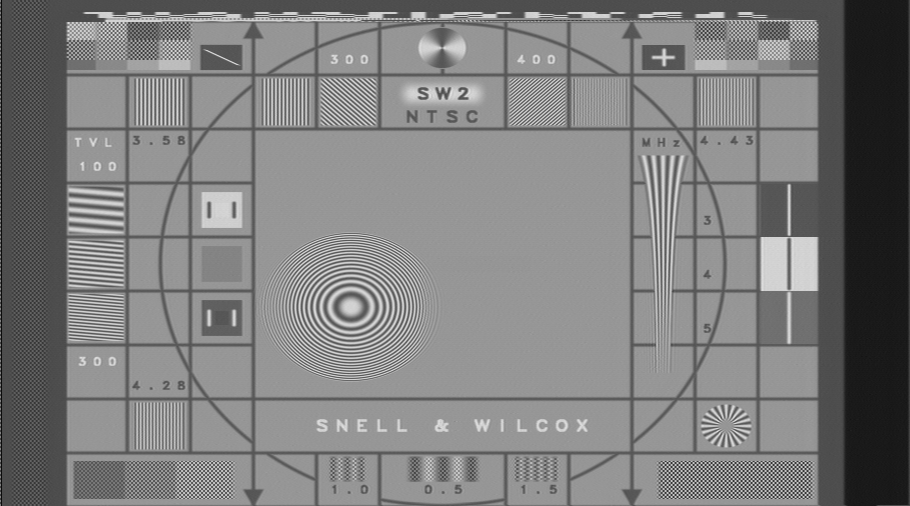

In [54]:
reduced = (combined - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

for i in range(0, 505, 2):
    if not lines_even_cburst[i // 2][0]:
        lines16[((i + 0) * 910)] = 32768
    else:
        lines16[((i + 0) * 910)] = 16384
        
    lines16[((i + 0) * 910) + 1] = np.uint16(327.67 * .8 * lines_even_cburst[i // 2][1])
    
    if not lines_odd_cburst[i // 2][0]:
        lines16[((i + 1) * 910)] = 32768
    else:
        lines16[((i + 1) * 910)] = 16384
        
    lines16[((i + 1) * 910) + 1] = np.uint16(327.67 * .8 * lines_odd_cburst[i // 2][1])

drawdata(lines16, 910, 506, hscale=1, vscale=1)

In [60]:
frameout = np.zeros((844 * 505), dtype=np.uint16)

offset = -8

for i in range(1, 505):
    frameout[(i + 0) * 844: (i + 1) * 844] = lines16[((i + 0) * 910) + offset: ((i + 0) * 910) + 844 + offset]
    frameout[(i + 0) * 844: ((i + 0) * 844) + 2] = lines16[((i + 0) * 910): ((i + 0) * 910) + 2]

In [61]:
outfile = open('tmp.tbc', 'wb')
outfile.write(frameout)

852440

In [46]:
# tbc effectiveness check - line length.  lineinfo3 is pretty even
#plt.plot(np.diff(lineinfo2[1:220]))
#plt.plot(np.diff(lineinfo_tmpa[1:220]))

NameError: name 'lineinfo_tmpa' is not defined

In [62]:
1.1*1.7

1.87

In [220]:
1.87+7.6

9.469999999999999

In [221]:
12.2-9.5

2.6999999999999993